# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present.  

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [17]:
import pandas as pd
import numpy as np
import category_encoders as ce
pd.set_option('display.max_columns', None)  # Unlimited columns
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [138]:
# Get a list of facility types to recognize in both training
# and testing datasets.  
X = train.copy()
feature = 'Facility Type'
X[feature] = X[feature].str.lower()
facilities_to_keep = X[feature].value_counts()[X[feature].value_counts() > 20].index.tolist()

In [50]:
# Same for Zips
feature = 'Zip'
X[feature] = X[feature].astype(str)
X[feature] = X[feature].str.lower()
zips_to_keep = X[feature].value_counts()[X[feature].value_counts() > 20].index.tolist()

In [60]:
# Same for Inspection Type
feature = 'Inspection Type'
X[feature] = X[feature].str.lower()
inspections_to_keep = X[feature].value_counts()[X[feature].value_counts() > 20].index.tolist()

In [147]:
# And for violations
new_violations = []
for row in X['Violations']:
    if type(row) == float:
        new_violations.append(np.nan)
    else:
        new_violations.append(row[:2].strip('.'))
        
X['Violations'] = new_violations
feature = 'Violations'
violations_to_keep = X['Violations'].value_counts()[X['Violations'].value_counts() > 100].index.tolist()

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

In [148]:
def wrangle(X):
    X = X.copy()
    
    # Delete useless columns
    garbage = ['License #','Location','Address','State',
               'AKA Name', 'DBA Name','Inspection ID','City']
    X = X.drop(columns=garbage)
    
    # Change all strings to lowercase
    for col in X.select_dtypes('object').columns:
        X[col] = X[col].str.lower()
    
    # Change Zip to a string, because it should be a categorical column
    # Change 'nan' to a proper NAN
    X['Zip'] = X['Zip'].astype(str)
    X['Zip'] = X['Zip'].replace('nan', np.nan)
    
    # Replace risk categories with numbers, so the model can
    # pick up on their order
    risk_dict = {'risk 1 (high)':1, 'risk 2 (medium)':2, 'risk 3 (low)':3}
    X['Risk'] = X['Risk'].replace(risk_dict)
    
    # Replace 'Inspection Date' with the number of days since the last inspection
    # This constitutes a new, engineered feature! [HINT HINT]
    X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True)
    X['Inspection Date'] = pd.Timestamp.today() - X['Inspection Date']
    X['Days since last inspection'] = X['Inspection Date'].dt.days
    X = X.drop(columns='Inspection Date')
    
    # Violations contains a wealth of information.
    # For now, I'm only extracting the first one mentioned
    # TODO: Get more out of it.
    new_violations = []
    for row in X['Violations']:
        if type(row) == float:
            new_violations.append(np.nan)
        else:
            new_violations.append(row[:2].strip('.'))
        
    X['Violations'] = new_violations
    
    # Use the list facilities_to_keep to remove facility types
    # with few numbers.
    new_facilities = X['Facility Type'].copy()
    new_facilities[~new_facilities.isin(facilities_to_keep)] = np.nan
    X['Facility Type'] = new_facilities
    
    # Use the list zips_to_keep to remove zips
    # with few numbers.
    new_zips = X['Zip'].copy()
    new_zips[~new_zips.isin(zips_to_keep)] = np.nan
    X['Zip'] = new_zips
    
    # Use the list inspections_to_keep to remove inspection types
    # with few numbers.
    new_insp = X['Inspection Type'].copy()
    new_insp[~new_insp.isin(inspections_to_keep)] = np.nan
    X['Inspection Type'] = new_insp
    
    #violations
    new_viols = X['Violations'].copy()
    new_viols[~new_viols.isin(violations_to_keep)] = np.nan
    X['Violations'] = new_viols
    
    # Alternative encoding
    encoder = ce.binary.BinaryEncoder(impute_missing=False)
    X = encoder.fit_transform(X)
    
    # Impute missing Lat/Long
    X['Latitude'] = X['Latitude'].fillna(np.mean(X['Latitude']))
    X['Longitude'] = X['Longitude'].fillna(np.mean(X['Longitude']))
    
    # Impute missing Risks
    X['Risk'] = X['Risk'].fillna(3)
    
    return X

In [149]:
X_train = wrangle(train)
print(X_train.shape)
X_train.head()

(51916, 30)


,Facility Type_0,Facility Type_1,Facility Type_2,Facility Type_3,Facility Type_4,Facility Type_5,Zip_0,Zip_1,Zip_2,Zip_3,Zip_4,Zip_5,Zip_6,Inspection Type_0,Inspection Type_1,Inspection Type_2,Inspection Type_3,Inspection Type_4,Inspection Type_5,Violations_0,Violations_1,Violations_2,Violations_3,Violations_4,Violations_5,Risk,Latitude,Longitude,Fail,Days since last inspection
0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1.0,41.938007,-87.644755,1,553
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,3.0,41.772402,-87.683603,0,2710
2,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,1.0,41.758779,-87.575054,0,1081
3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2.0,41.812181,-87.707125,0,1057
4,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1.0,41.879568,-87.676663,0,2993


### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._

#### XGBoost
This one didn't work at all.  Jump over to random forest

In [81]:
import xgboost as xgb
X_train = wrangle(train)
X_test = wrangle(test)

In [88]:
features = X_train.drop(columns='Fail').columns.tolist()
dtrain = xgb.DMatrix(X_train[features], label=X_train['Fail'])
dtest = xgb.DMatrix(X_test[features], label=X_test['Fail'])

In [110]:
params = {'monotone_constraints': '(0)', # no constraint
          'max_depth': 2,
          'subsample':0.9,
          'eta': 0.1,
          'silent': 1, 
          'n_jobs': -1,
          'seed': 0,
          'eval_metric': 'auc'}

# bst_cv = xgb.cv(params, 
#                 dtrain, 
#                 num_boost_round=1000, 
#                 nfold=5, 
#                 early_stopping_rounds=10, 
#                 as_pandas=True)

In [111]:
# bst_cv[['train-auc-mean', 'test-auc-mean']].plot();

In [112]:
bst = xgb.train(params, dtrain, num_boost_round=200)
print(bst.eval(dtest))

[0]	eval-auc:0.511471


In [100]:
%%time
modelxgb = XGBClassifier(booster = 'dart', 
                         n_jobs=-1)

X = X_train.drop(columns='Fail')
y = X_train['Fail']
# cv_score = cross_val_score(modelxgb, X, y,
#                            scoring='roc_auc', 
#                            cv=5)

CPU times: user 10.8 ms, sys: 23.7 ms, total: 34.4 ms
Wall time: 34.7 ms


In [76]:
# cv_score

In [103]:
modelxgb.fit(X,y)
X_test = wrangle(test).drop(columns='Fail')
y_true = test['Fail']
y_test = modelxgb.predict_proba(X_test)[:,1]

score = roc_auc_score(y_true, y_test)
score

0.5028557234595509

#### Random forest

In [150]:
X_train=wrangle(train)
X_test=wrangle(test)

forest = RandomForestClassifier(
                n_estimators=500, 
                max_depth=5,
#                 class_weight='balanced', 
                min_samples_leaf=0.05, 
                oob_score=False, 
                n_jobs=-1)

X = X_train.drop(columns='Fail')
y = X_train['Fail']

forest.fit(X, y)

X_test = wrangle(test).drop(columns='Fail')
y_true = test['Fail']
y_test = forest.predict_proba(X_test)[:,0]

score = roc_auc_score(y_true, y_test)
score

0.5172685043076104

In [114]:
# cv_score = cross_val_score(forest, X, y,
#                            scoring='roc_auc', 
#                            cv=5)
# cv_score

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

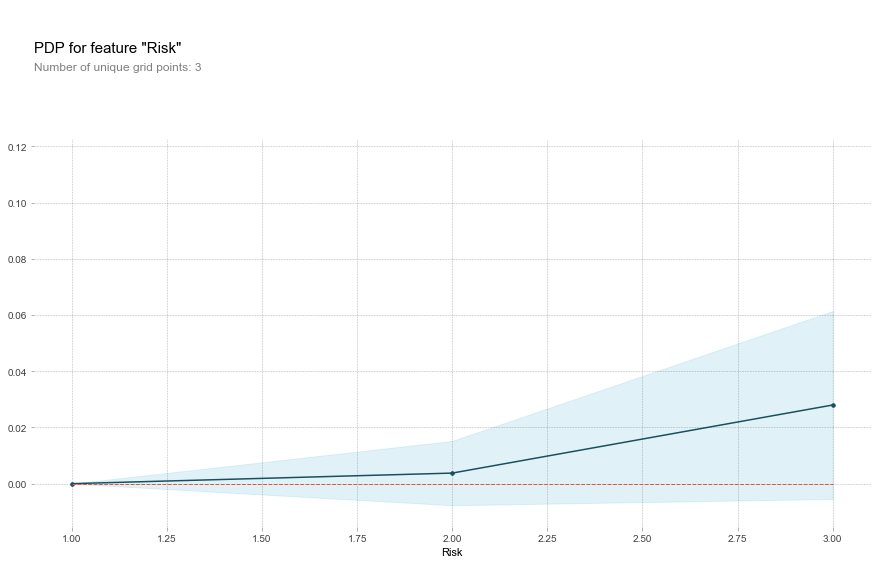

In [40]:
from pdpbox.pdp import pdp_isolate, pdp_plot
feature='Risk'
pdp_isolated = pdp_isolate(model=forest, dataset=X, model_features=X.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

In [41]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=forest,
                             scoring='roc_auc',
                             n_iter=1,
                             cv='prefit'
                            ).fit(X, y)
eli5.show_weights(perm, 
                  top=None, 
                  feature_names=X.columns.tolist())

Weight,Feature
0.2071 ± 0.0000,Violations_3
0.0685 ± 0.0000,Violations_5
0.0586 ± 0.0000,Violations_2
0.0469 ± 0.0000,Violations_6
0.0212 ± 0.0000,Violations_4
0.0137 ± 0.0000,Inspection Type_4
0.0136 ± 0.0000,Violations_1
0.0120 ± 0.0000,Inspection Type_5
0.0063 ± 0.0000,Days since last inspection
0.0055 ± 0.0000,Inspection Type_6
